In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:

def modified_lsm(input):
    # Excitatory neurons    Inhibitory neurons
    Ne = 80
    Ni = 20
    re = np.random.rand(Ne)
    ri = np.random.rand(Ni)
    a = np.concatenate([0.02 * np.ones(Ne), 0.02 + 0.08 * ri])
    b = np.concatenate([0.2 * np.ones(Ne), 0.25 - 0.05 * ri])
    c = np.concatenate([-65 + 15 * re ** 2, -65 * np.ones(Ni)])
    d = np.concatenate([8 - 6 * re ** 2, 2 * np.ones(Ni)])

    # scaling of input connections
    win_e = 0.7 #5
    win_i = 0.2 #2
    U = np.concatenate([win_e * np.ones(Ne), win_i * np.ones(Ni)])

    # scaling of recurrent connections
    w_e = 0.8 #0.5
    w_i = 1 #1
    S = np.concatenate([w_e * np.random.rand(Ne + Ni, Ne), -w_i * np.random.rand(Ne + Ni, Ni)], axis=1)

    v = -65 * np.ones(Ne + Ni)    # Initial values of v
    u = b * v                     # Initial values of u
    firings = []                  # spike timings

    states = []  # here we construct the matrix of reservoir states

    for t in range(input.shape[0]):  # simulation of 1000 ms
        # we don't need random thalamic input:
        # I=[5*randn(Ne,1);2*randn(Ni,1)]; % thalamic input
        # we use instead the input from the external time series!
        I = input[t] * U
        fired = np.where(v >= 30)[0]    # indices of spikes
        firings.append(np.concatenate([t + np.zeros(len(fired)).reshape(-1, 1), fired.reshape(-1, 1)], axis=1))
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]

        I = I + np.sum(S[:, fired], axis=1)
        v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)    # step 0.5 ms
        v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)    # for numerical stability
        u = u + a * (b * v - u)

        states.append((v >= 30).astype(int))

    firings = np.concatenate(firings, axis=0)
    plt.figure(figsize = (20,5))
    plt.plot(firings[:, 0], firings[:, 1], '.')
    plt.show()

    # in the end states is 1000 x number of time steps
    states = np.array(states).T
    return states

2899
2398


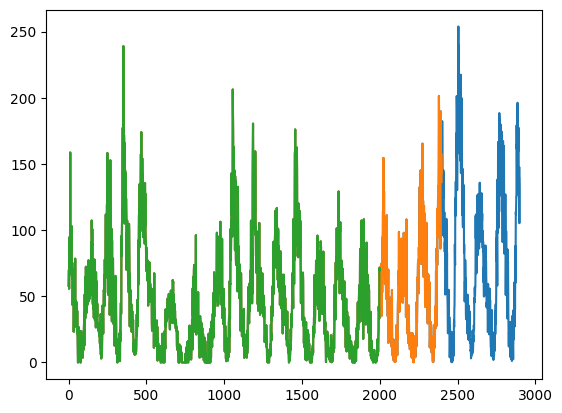

In [3]:
#import dataset

whole_dataset = np.loadtxt("solar_data.csv", delimiter=",")
print(len(whole_dataset))
input_dataset = whole_dataset[:2398]
print(len(input_dataset))
test_set = whole_dataset[2398:]


t=np.arange(start=0,stop=len(whole_dataset), step=1)
ti=np.arange(start=0,stop=len(input_dataset), step=1)
plt.plot(t,whole_dataset)
plt.plot(ti,input_dataset)

training_set = input_dataset[:2000]
validation_set = input_dataset[2000:]

tt=np.arange(start=0,stop=len(training_set), step=1)
plt.plot(tt,training_set)


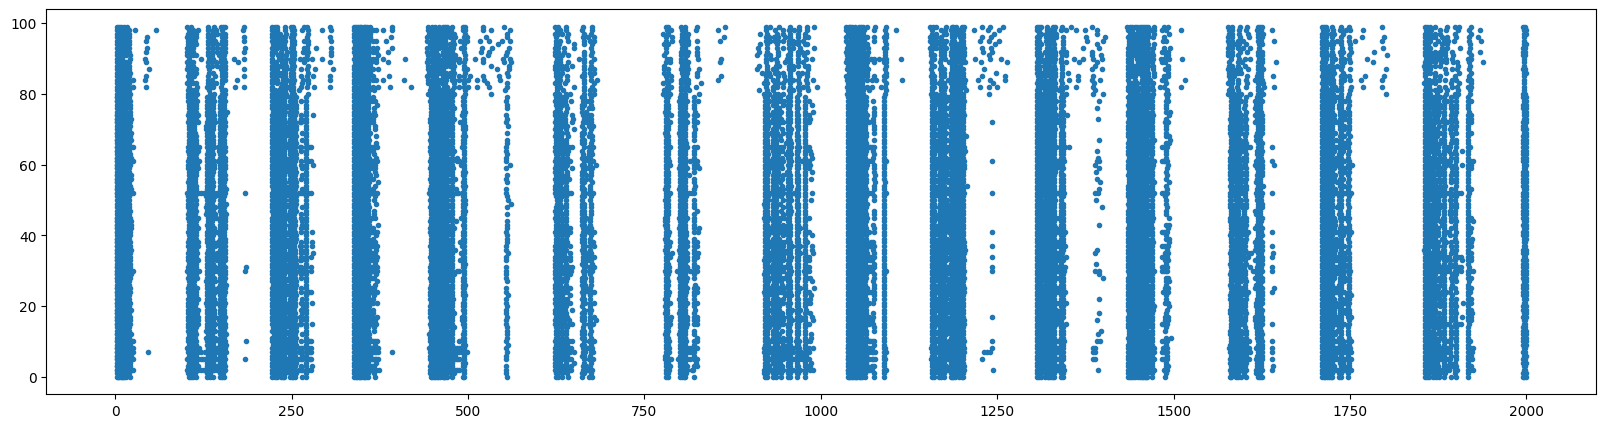

(100, 2000)
(2000,)
(100,)
(398,)


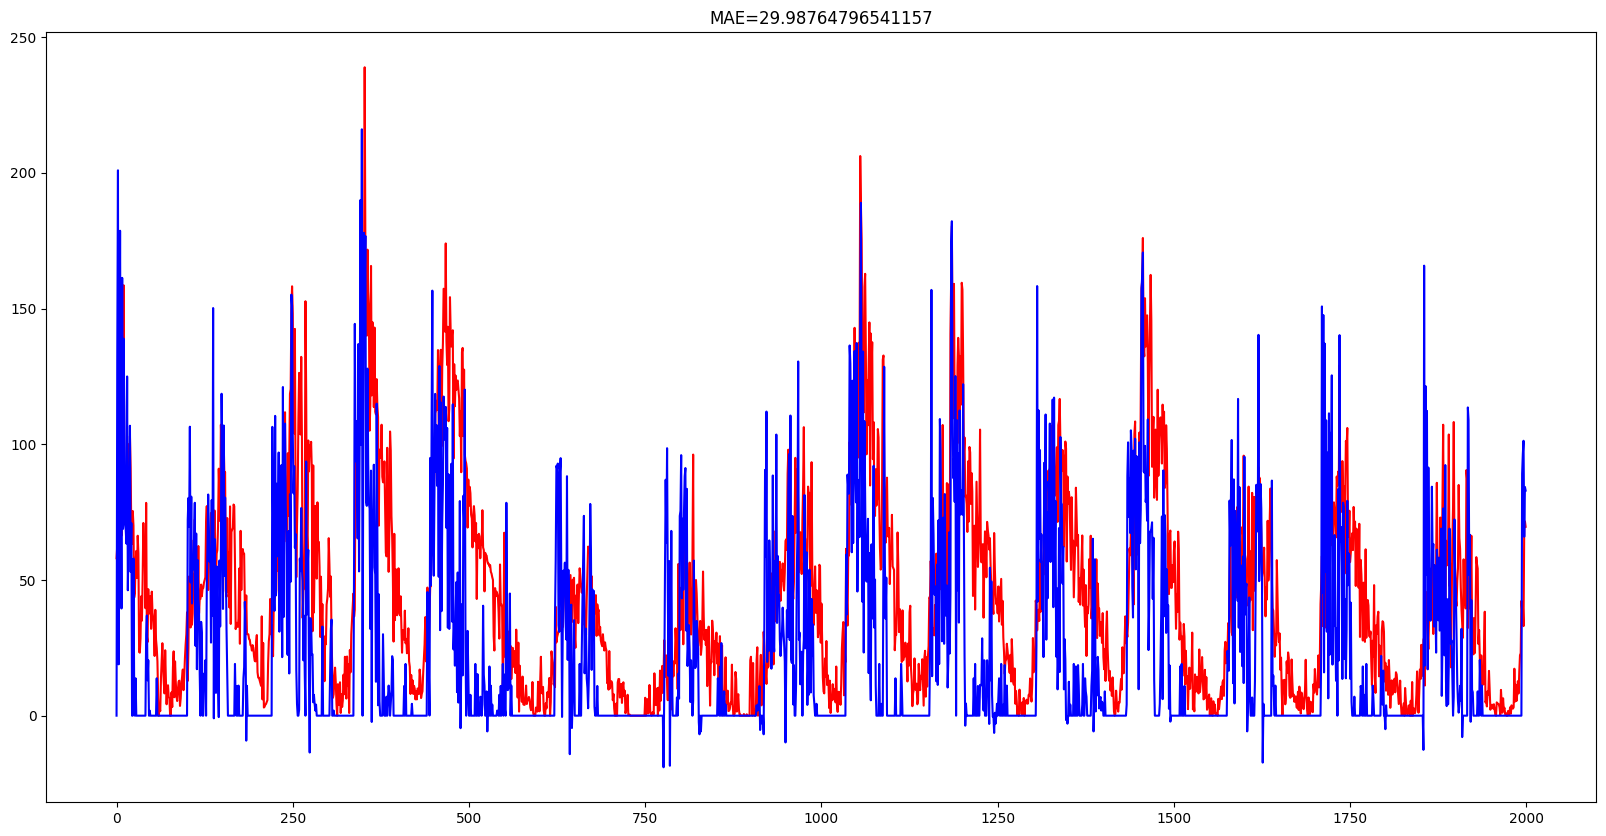

In [6]:
trainStates = modified_lsm(training_set)

print(np.shape(trainStates))
print(training_set.shape)

Wout = np.dot(training_set,np.linalg.pinv(trainStates))

print(Wout.shape)
print(validation_set.shape)


trainOutput = np.dot(Wout, trainStates)



plt.figure(figsize = (20,10))
t=np.arange(start=0,stop=len(training_set), step=1)
mae = mean_absolute_error(training_set, trainOutput)
plt.title(f'MAE={mae}')
plt.plot(t,training_set, color='red')
plt.plot(t,trainOutput, color = 'blue')
plt.show()


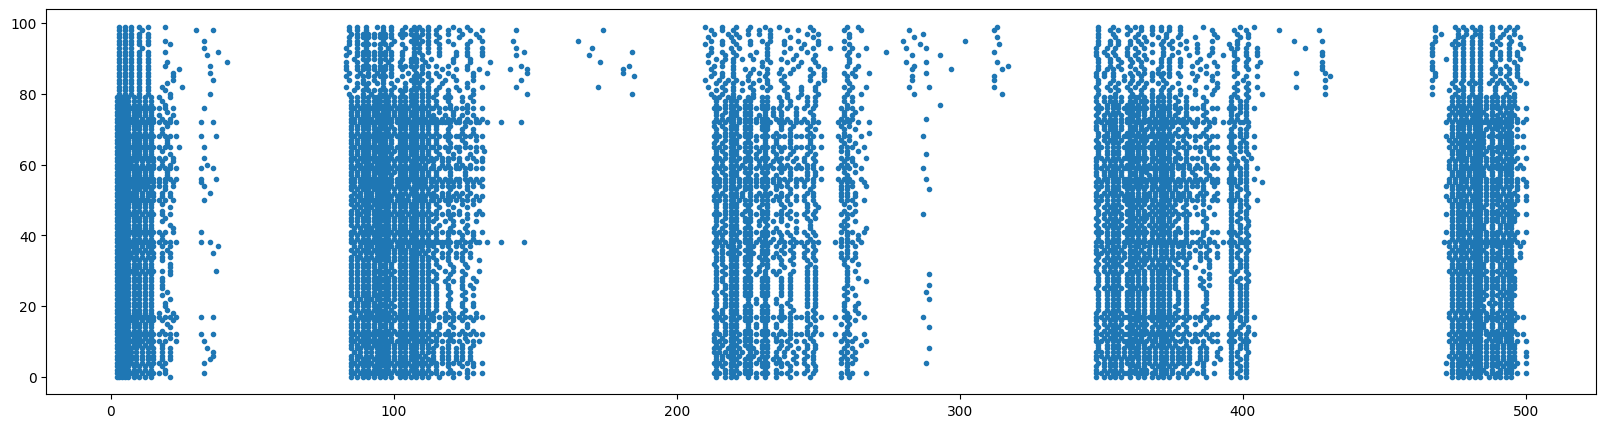

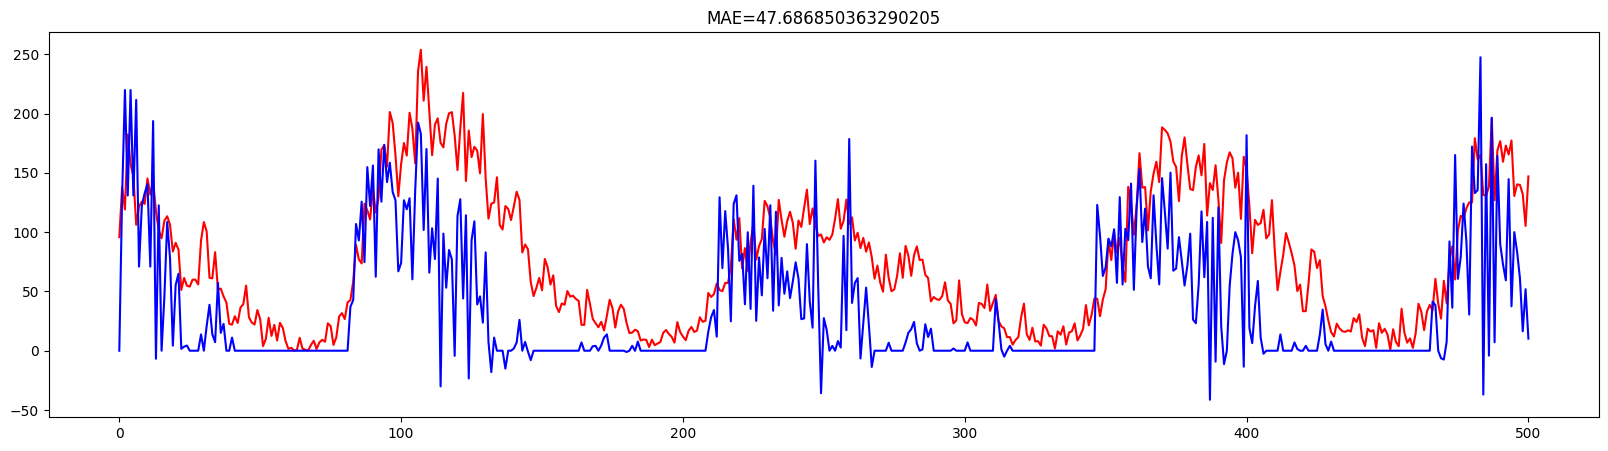

In [7]:
testStates = modified_lsm(test_set)

testOutput = np.dot(Wout, testStates)



plt.figure(figsize = (20,5))
t=np.arange(start=0,stop=len(test_set), step=1)
mae = mean_absolute_error(test_set, testOutput)
plt.title(f'MAE={mae}')
plt.plot(t,test_set, color='red')
plt.plot(t,testOutput, color = 'blue')
plt.show()